# Clustering

### 1. Imports e configuração inicial

In [1]:
import sys
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")

from src.data_loader import load_raw_data
from src.features import process_pipeline
from src.clustering import run_clustering_pipeline



### 2. Carga e preparação dos dados

In [3]:
DATA_PATH = os.path.join(
    PROJECT_ROOT,
    "data",
    "raw",
    "credit_card_clients.xls"
)


df_raw = load_raw_data(DATA_PATH)

print("Shape do dataset bruto:", df_raw.shape)
df_raw.head()


Tentando carregar: c:\Users\viras\OneDrive\Área de Trabalho\Workspace\GitHub\inadimplencia-segmentacao\data\raw\credit_card_clients.xls
✅ Arquivo detectado como Excel (.xls) e carregado com sucesso.
Shape do dataset bruto: (30000, 25)


,id,limite_credito,genero,escolaridade,estado_civil,idade,status_pag_set,status_pag_ago,status_pag_jul,status_pag_jun,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,is_inadimplente
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


#### Feature engineering

In [4]:
# Feature engineering e enriquecimento comportamental
df_feat = process_pipeline(df_raw)

print("Shape após feature engineering:", df_feat.shape)
df_feat.head()


Shape após feature engineering: (30000, 31)


,limite_credito,genero,escolaridade,estado_civil,idade,status_pag_set,status_pag_ago,status_pag_jul,status_pag_jun,status_pag_mai,...,pay_amt5,pay_amt6,is_inadimplente,score_gravidade,freq_atrasos,taxa_uso_limite,razao_pagamento_6m,canal_preferido,atende_cobranca,perfil_atendimento
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,1,8,2,0.195650,0.089434,WhatsApp,False,Evasivo
1,120000,2,2,2,26,-1,2,0,0,0,...,0,2000,1,8,2,0.022350,0.292791,Telefone,False,Evasivo
2,90000,2,2,2,34,0,0,0,0,0,...,1000,5000,0,0,0,0.324878,0.108388,Telefone,False,Evasivo
3,50000,2,2,1,37,0,0,0,0,0,...,1069,1000,0,0,0,0.939800,0.036259,Email,True,Engajado
4,50000,1,2,1,57,-1,0,-1,0,0,...,689,679,0,0,0,0.172340,0.540054,SMS,True,Engajado


### 3. Sanity checks antes do clustering

#### Conferência estatística das features de clustering

In [5]:
features_clustering = [
    "score_gravidade",
    "razao_pagamento_6m",
    "taxa_uso_limite",
    "limite_credito"
]

df_feat[features_clustering].describe().T


,count,mean,std,min,25%,50%,75%,max
score_gravidade,30000.0,3.941967,12.755546,0.0,0.000000,0.000000,4.000000,264.0
razao_pagamento_6m,30000.0,0.346925,0.381880,0.0,0.043163,0.106452,0.718489,1.0
taxa_uso_limite,30000.0,0.421249,0.399475,0.0,0.022032,0.313994,0.829843,1.5
limite_credito,30000.0,167484.322667,129747.661567,10000.0,50000.000000,140000.000000,240000.000000,1000000.0


### 4. Execução do clustering

In [6]:
N_CLUSTERS = 4

df_clustered = run_clustering_pipeline(
    df_feat,
    n_clusters=N_CLUSTERS
)

df_clustered["cluster"].value_counts().sort_index()


⚙️ Treinando KMeans com n_clusters=4...
📊 Silhouette Score: 0.3921


cluster
0     9459
1     6366
2    14046
3      129
Name: count, dtype: int64

#### Interpretação dos clusters

In [7]:
cluster_profile = (
    df_clustered
    .groupby("cluster")
    .agg({
        "score_gravidade": "mean",
        "freq_atrasos": "mean",
        "razao_pagamento_6m": "mean",
        "taxa_uso_limite": "mean",
        "limite_credito": "mean",
        "is_inadimplente": "mean"
    })
    .round(3)
)

cluster_profile


,score_gravidade,freq_atrasos,razao_pagamento_6m,taxa_uso_limite,limite_credito,is_inadimplente
cluster,,,,,,
0,0.960,0.372,0.870,0.029,211161.856,0.178
1,1.728,0.449,0.160,0.290,292464.292,0.131
2,5.566,1.274,0.083,0.744,82190.090,0.287
3,155.016,5.899,0.011,0.514,84341.085,0.690


### 4. Validação dos clusters

#### Inadimplência por cluster

In [8]:
inad_por_cluster = (
    df_clustered
    .groupby("cluster")["is_inadimplente"]
    .agg(["mean", "count"])
    .rename(columns={"mean": "taxa_inadimplencia", "count": "n_clientes"})
)

inad_por_cluster


,taxa_inadimplencia,n_clientes
cluster,,
0,0.177503,9459
1,0.131323,6366
2,0.287057,14046
3,0.689922,129


#### Visualização intuitiva da separação

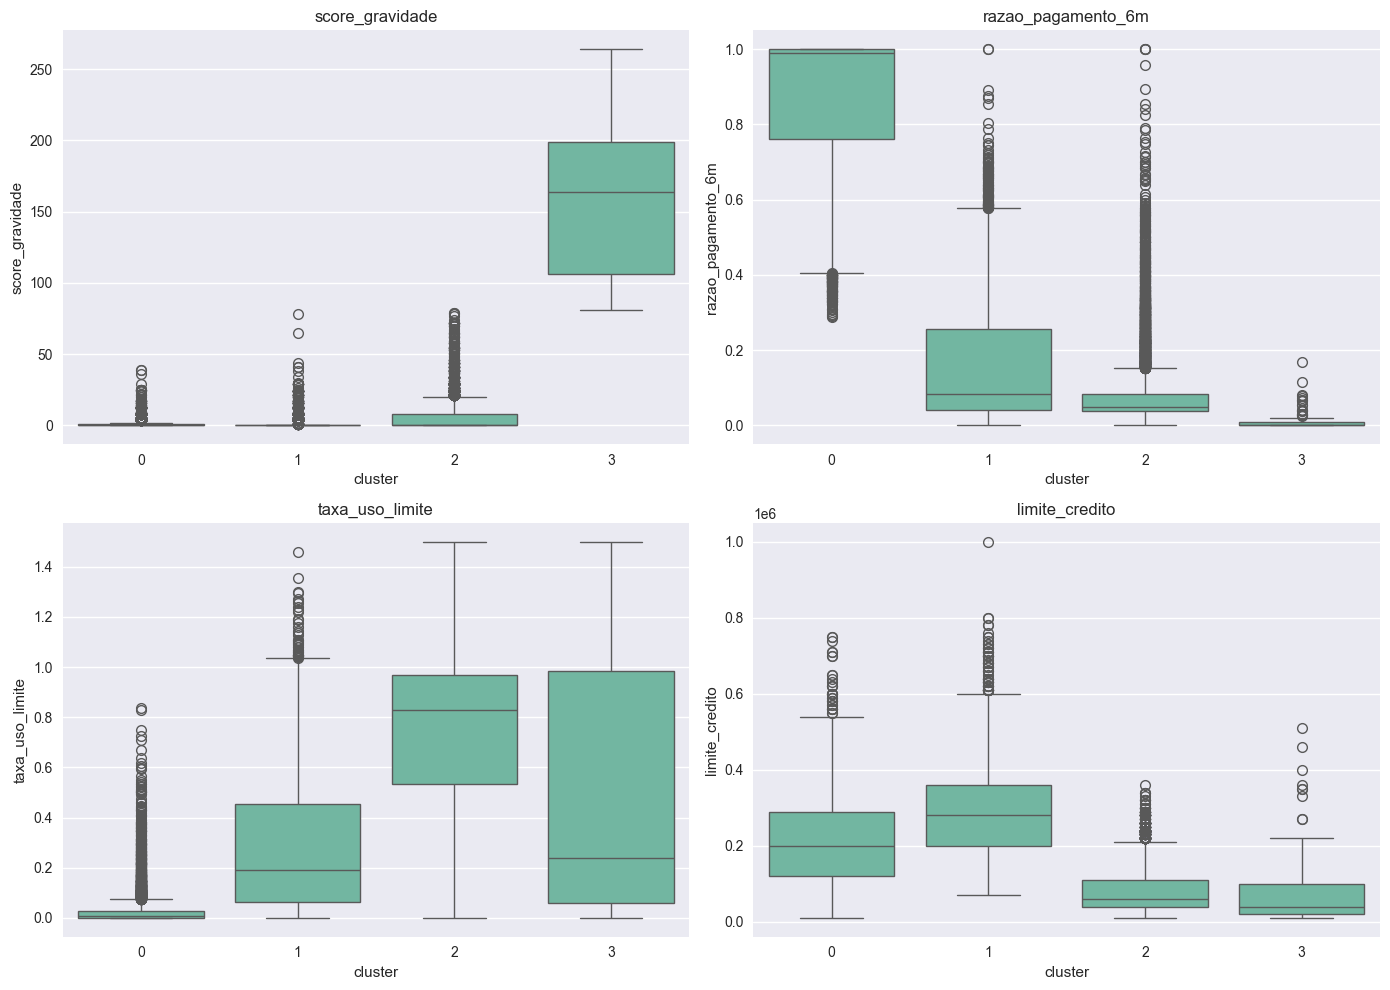

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

features_plot = [
    "score_gravidade",
    "razao_pagamento_6m",
    "taxa_uso_limite",
    "limite_credito"
]

for ax, feature in zip(axes.flatten(), features_plot):
    sns.boxplot(
        data=df_clustered,
        x="cluster",
        y=feature,
        ax=ax
    )
    ax.set_title(feature)

plt.tight_layout()


#### Cluster x Target

In [10]:
pd.crosstab(
    df_clustered["cluster"],
    df_clustered["is_inadimplente"],
    normalize="index"
).round(3)



is_inadimplente,0,1
cluster,,
0,0.822,0.178
1,0.869,0.131
2,0.713,0.287
3,0.310,0.690
